<a href="https://colab.research.google.com/github/cuboidandroid/LocalTransformer/blob/main/LocalTransformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

# from gspread_dataframe import set_with_dataframe
# from google.colab import auth
# auth.authenticate_user()

# import gspread
# from google.auth import default
# creds, _ = default()

# gc = gspread.authorize(creds)

In [ ]:
df = pd.DataFrame()
t = np.linspace(0,np.pi/2,100)
df['x'] = t
df['y'] = 1-t**2
df['yaw_angle'] = -t
df['obj_x'] = 3*np.ones(100)
df['obj_y'] = -1*np.ones(100)
df.head(3)

,x,y,yaw_angle,obj_x,obj_y
0,0.000000,1.000000,-0.000000,3.0,-1.0
1,0.015867,0.999748,-0.015867,3.0,-1.0
2,0.031733,0.998993,-0.031733,3.0,-1.0


In [ ]:
class LocalTransformer(BaseEstimator, TransformerMixin):
  """
  Moves object to local coordinate system for the referer moving object.
  Global position of referer is specified in columns annotated with
  x_referer, y_referer, angle_referer.
  Global position of object in columns is annotated with
  x_target, y_target
  Adds two additional columns with x_target_local and y_target_local
  """
  def __init__(self, x_referer, y_referer, angle_referer, x_target, y_target):
    self.x_referer = x_referer
    self.y_referer = y_referer
    self.angle_referer = angle_referer
    self.x_target = x_target
    self.y_target = y_target

    self.x_target_local = f'{self.x_target}_local'
    self.y_target_local = f'{self.y_target}_local'

  def fit(self, X, y=None):
    return self

  def transform(self, X):
    if isinstance(X, pd.DataFrame):
      X2 = X.copy()

      # TRANSLATE TO REFERER POSITION
      X2[self.x_target_local] = X2[self.x_target] - X2[self.x_referer]
      X2[self.y_target_local] = X2[self.y_target] - X2[self.y_referer]

      # ROTATE TO REFERER ANGLE
      M_alpha = np.array([[np.cos(-X[self.angle_referer]), -np.sin(-X[self.angle_referer])],
                          [np.sin(-X[self.angle_referer]), np.cos(-X[self.angle_referer])]])

      P = X2[[self.x_target_local, self.y_target_local]].to_numpy().T

      P_prime = np.einsum('ijt,jt->it', M_alpha, P)

      X2.loc[:, [self.x_target_local, self.y_target_local]] = P_prime.T

      return X2
    else:
      NotImplementedError

In [ ]:
pipe = Pipeline(
    [('local_transformer', LocalTransformer(x_referer='x',
                                            y_referer='y',
                                            angle_referer='yaw_angle',
                                            x_target='obj_x',
                                            y_target='obj_y'
                                            ))]
    )
pipe

Pipeline(steps=[('local_transformer',
                 LocalTransformer(angle_referer='yaw_angle', x_referer='x',
                                  x_target='obj_x', y_referer='y',
                                  y_target='obj_y'))])

In [ ]:
dft = pipe.fit_transform(df)
dft.head(3)

,x,y,yaw_angle,obj_x,obj_y,obj_x_local,obj_y_local
0,0.000000,1.000000,-0.000000,3.0,-1.0,3.000000,-2.00000
1,0.015867,0.999748,-0.015867,3.0,-1.0,3.015486,-1.95215
2,0.031733,0.998993,-0.031733,3.0,-1.0,3.030196,-1.90381


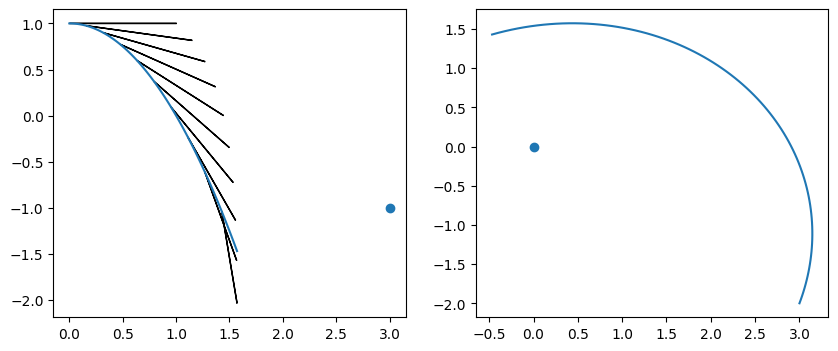

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,2, figsize=(10,4))

axs[0].plot(df.x, df.y)
axs[0].scatter([3], [-1])
for i in df.index:
  if i % 10 == 0:
    axs[0].arrow(df.loc[i, 'x'], df.loc[i, 'y'], dx=np.cos(df.loc[i, 'yaw_angle']), dy=np.sin(df.loc[i, 'yaw_angle']), )


axs[1].plot(dft['obj_x_local'], dft['obj_y_local'])
axs[1].scatter([0], [0])

plt.show()